In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL  = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


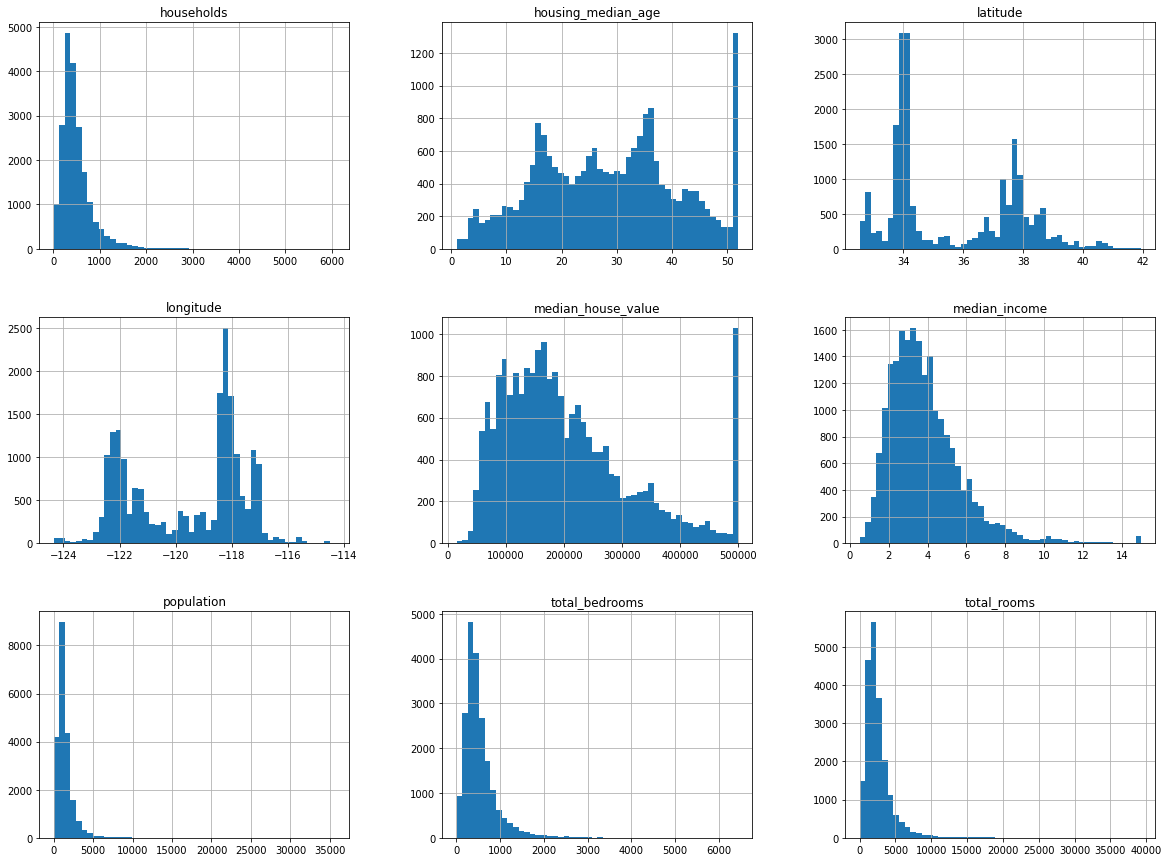

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
# create test set

import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = split_train_test(housing, 0.2)


In [8]:
len(train_set)


16512

In [9]:
len(test_set)

4128

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

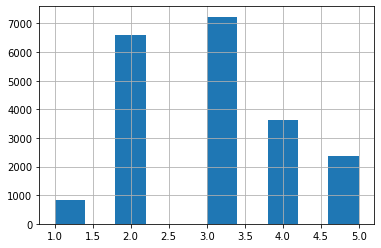

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.,1.5,3.0,4.5, 6., np.inf],
                              labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Analysing the data

In [15]:
# copy set to play with so training set isn't mutated
housing = strat_train_set.copy()

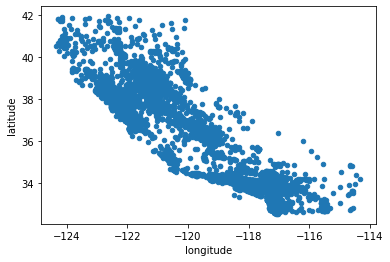

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude")

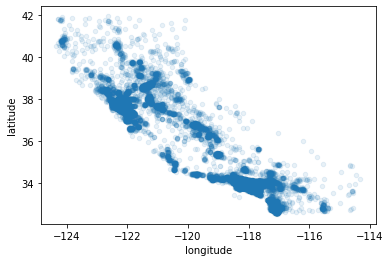

In [17]:
# modify opacity (alpha) of each instance so we can see where they bunch up
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

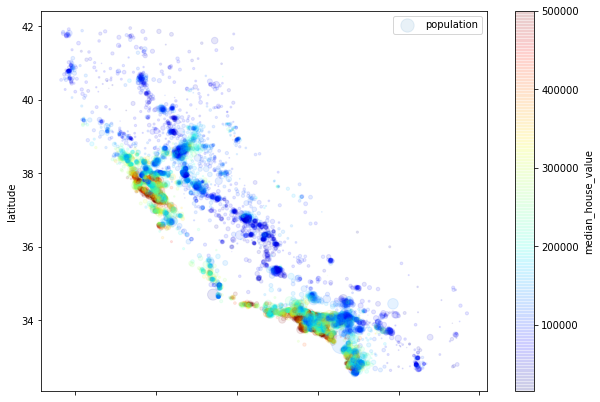

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [19]:
#compute standard correlation coefficient 
corr_matrix = housing.corr()

In [20]:
# when value is close to 1 there is a strong positive correlation: 
# e.g median house value tends to go up when the median_income goes up
# when value is close to -1 there is a strong negative correlation:
# e.g median house value has a slight tendency to go down when you go north
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

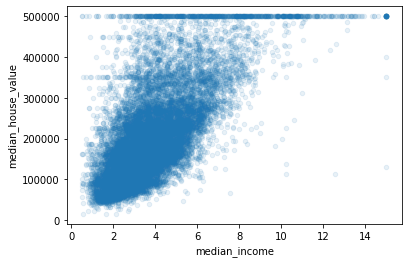

In [21]:
# as median income seems to be the most proimising predictor of median house value we take a closer look

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

# we also see a few horizontal lines which we may try to remove so that the alogrithms doesn't learn from and reproduce these data quirks

In [22]:
# experimenting with various promising attribution combinations to try to find more correlations

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Preparing the data for machine learning

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Cleaning the data

In [25]:
# fix total_bedrooms missing data
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [26]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [28]:
housing_cat = housing[["ocean_proximity"]]

In [29]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [30]:
# most ML algorithsm prefer to work with numbers so we convert these values to numbers

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [31]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [32]:
#however, using this method means ML algorithms will assume two nearby values are closer than two distant values
# to fix this we use a method known as one-hot encoding which gives each category a binary attribute 
# so there is no way of inferring similarity based on a category's index.

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [33]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Feature Scaling

Feature scaling is a solution to normalising different attribute scales. Having numerical attributes with different scales don't perform well and therefore we must try to normalise them:

1. min-max scaling
    - values shifted and rescaled so that they range from 0 to 1. achieved by subtracting the min value and dividing by the max minus the min.
2. standardization:
    - Subtracts the mean value and then divides by the standard deviation

## Transformation pipelines

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix]/ X[:, households_ix]
        population_per_household  = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [36]:
# a single trasnformer to handle both categorical and numerical columns

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

# Select & Train a Model

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [41]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [42]:
print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


## Model Evaluation

In [44]:
# measuring thge regression model's RMSE

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse  = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

#as RMSE is so high, it is likely that the model is underfitting the training data 

68628.19819848922

In [45]:
# using a DecisionTreeRegressor model instead to try to reduce RMSE
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [46]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#as RMSE is so LOW, it indicates that the model is badly overfitting the data

0.0

## Evaluating models with Cross-Validation
One way to evaluate a model is to split the training set into a smaller training set and a validation set, then train the models against the smaller training set and evaluate them against the validation set. 

However, another way is to use Scikit-Learn's cross-validation feature which splits the training set into 10 distinct subsets which is then trains and evaluates the model on 10 times, picking a different subset each time and training on the other 9 subsets.

In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

# cross validation fucntion takes in a utility function where greater is better rather than MSE's less is better
# hence, we do -scores to account for this as it is essentially the opposite of the MSE
tree_rmse_scores = np.sqrt(-scores)

In [48]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [50]:
display_scores(tree_rmse_scores)

Scores: [69247.30071863 66441.93008946 70028.63802031 68998.67253642
 72066.15255413 76760.9750841  69783.48765316 71087.59466069
 76446.27081991 68998.13454089]
Mean: 70985.9156677705
Standard deviation: 3134.920247331243


Here it shows that instead of being perfect, the model is actually worse than the linear regression model which we'll confirm here:

In [51]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [52]:
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


The goal at this stage is to have a shortlist of 2-5 promising models which you can then begin fine-tuning to try to improve performance


# Fine-Tuning Your Model

## Grid Search
Uses cross-validation to evaluate all possible combinations of hyperparameter values

## Randomised Search
When hyperparameter search space is large, instad of using Grid Search it is preferable to use Randomised Search. 
It evaluates a given number of random combinations by sleecting a random value for each hyperparameter at every iteration. 

## Ensemble Methods
Another way to fine-tune is by combining models that perform the best. The group (ensemble) will often perform better than the best individual model.

## Analysing the best models and their errors
Once you have identified the best model you should go and look at the errors associated with it as you may be able to garner insight and fix the issues.

## Evaluating the system on the test set
Once you have tweaked your models for a while and found a system that performs sufficiently well it is time to evaluate the final model on the test set. It will be the same process as when we ran it on the training set

# Launch, Monitor & Maintain The System
Once model is trained it can be deployed to production environment. 
One way to do this is by saving the trained model via jotlib andloading it in the production environment and simply calling its predict(method) with the new data that can be transmitted from frontend -> backend via a REST API.

Another option is deploying the model on the cloud (Google Cloud for example)

## Monitoring The System
It is important to write monitoring code to check the model's live performance at regular intervals and trigger alerts when it drops. This is because models tend to rot over time when the world changes and therefore the dat ait was trained on is no longer as relevant as it initially was. 

Monitoring tasks that can be automated:
    - Collecting fresh data regularly and labelling it (MTurk, etc)
    - Write a script to train the model and fine-tune hyperparameters automatically
    - Write a script that evaluates new model's performance and deploys it if it is better than existing one in production

# Exercises